In [106]:
import json
import bz2
import regex
from scipy import sparse
import igraph as ig
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
tqdm.pandas()
from rusenttokenize import ru_sent_tokenize
import re
from pymystem3 import Mystem
from gensim.models import Word2Vec
from collections import Counter
from sklearn.manifold import TSNE

In [99]:
import pandas as pd
import numpy as np
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[1]

{'city': 'г. Новосибирск',
 'rating_not_checked': False,
 'title': 'Не могу пользоваться услугой Сбербанк он-лайн',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'Foryou',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-08 11:09:57',
 'text': 'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня про

## Часть 1. Обучение модели word2vec [50 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [5]:
# Перегоняем отзывы в dataframe
df = pd.DataFrame(responses)
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку


In [6]:
df.loc[1]['text']

'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня пробивают по базе - опять числюсь СЕКЛЕТИНОЙ (хотя карту уже перевыпустили еще раз на фамилию ТОКАРЕВА в связи с истечением срока обслуживания). Высылаю документы (копию паспорта и свидетельства о браке). Результат \xa0- 0 (ноль). ПРошу помочь разобраться в этой ситуации. С

In [7]:
regex = re.compile("[а-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [10]:
words_only(df.loc[1]['text'].lower())

'доброго дня являюсь держателем зарплатной карты выданной сбербанком россии в году сменила фамилию предоставила в банк документы копию нового паспорта свидетельства о браке мне перевыпустили карту на фамилию мужа токарева мария александровна девичья секлетина возникла необходимость подключить услугу сбербанк онлайн не получилось на главной странице на отображались мои карты связалась с техническим специалистом отделения сбербанка в котором обслуживалась он пояснил что в базе банка я все ещ под девичьей фамилией секлетина предложил выслать сканы необходимых документов выслала оставив контакты звонка так и не дождалась ч з некоторое время звоню сама объясняю ситуацию меня пробивают по базе опять числюсь секлетиной хотя карту уже перевыпустили еще раз на фамилию токарева в связи с истечением срока обслуживания высылаю документы копию паспорта и свидетельства о браке результат ноль прошу помочь разобраться в этой ситуации с уважением токарева мария александровна'

In [8]:
def sentences(text):
    try:
        return [words_only(sent.lower()) for sent in ru_sent_tokenize(text)]
    except:
        return []    


In [12]:
sentences(df.loc[1]['text'])

['доброго дня',
 'являюсь держателем зарплатной карты выданной сбербанком россии',
 'в году сменила фамилию предоставила в банк документы копию нового паспорта свидетельства о браке мне перевыпустили карту на фамилию мужа токарева мария александровна девичья секлетина',
 'возникла необходимость подключить услугу сбербанк онлайн не получилось на главной странице на отображались мои карты',
 'связалась с техническим специалистом отделения сбербанка в котором обслуживалась',
 'он пояснил что в базе банка я все ещ под девичьей фамилией секлетина',
 'предложил выслать сканы необходимых документов',
 'выслала оставив контакты звонка так и не дождалась',
 'ч з некоторое время звоню сама объясняю ситуацию меня пробивают по базе опять числюсь секлетиной хотя карту уже перевыпустили еще раз на фамилию токарева в связи с истечением срока обслуживания',
 'высылаю документы копию паспорта и свидетельства о браке',
 'результат ноль',
 'прошу помочь разобраться в этой ситуации',
 'с уважением токарев

In [14]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def remove_stopwords(sentences, mystopwords = mystopwords):
    try:
        out = []
        for sentence in sentences:
            out.append(" ".join([token for token in sentence.split() if not token in mystopwords]))
        return out
    except:
        return []

In [15]:
remove_stopwords(sentences(df.loc[1]['text']))

['доброго дня',
 'являюсь держателем зарплатной карты выданной сбербанком россии',
 'году сменила фамилию предоставила банк документы копию нового паспорта свидетельства браке перевыпустили карту фамилию мужа токарева мария александровна девичья секлетина',
 'возникла необходимость подключить услугу сбербанк онлайн получилось главной странице отображались мои карты',
 'связалась техническим специалистом отделения сбербанка котором обслуживалась',
 'пояснил базе банка ещ девичьей фамилией секлетина',
 'предложил выслать сканы необходимых документов',
 'выслала оставив контакты звонка дождалась',
 'ч з некоторое время звоню сама объясняю ситуацию пробивают базе числюсь секлетиной хотя карту перевыпустили фамилию токарева связи истечением срока обслуживания',
 'высылаю документы копию паспорта свидетельства браке',
 'результат ноль',
 'прошу помочь разобраться ситуации',
 'уважением токарева мария александровна']

In [16]:
mystem = Mystem()
def mystem_lemmas(sentences, mystem=mystem):
    res = []
    for sentence in sentences:
        try:
            res.append([l for l in mystem.lemmatize(sentence) if l.isalpha()])
        except:
            pass
    return res

In [25]:
mystoplemmas = ['который','прошлый','сей', 'свой', 'наш', 'мочь']

In [30]:
def remove_stoplemmas(sentences):
    res = []
    for sentence in sentences:
        if len(sentence) > 0:
            res.append([lemma for lemma in sentence if not lemma in mystoplemmas])
    return res

In [41]:
def preprocessing(text):
    sents = sentences(text)
    no_stopwords = remove_stopwords(sents)
    lemmas = mystem_lemmas(no_stopwords)
    no_stoplemmas = remove_stoplemmas(lemmas)
    flat_lemmas = [lemma for sentence in no_stoplemmas for lemma in sentence]
    return flat_lemmas

In [42]:
%%time
preprocessing(df.loc[1]['text'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.77 ms


['добрый',
 'день',
 'являться',
 'держатель',
 'зарплатной',
 'карта',
 'выдавать',
 'сбербанк',
 'россия',
 'год',
 'сменить',
 'фамилия',
 'предоставлять',
 'банк',
 'документ',
 'копия',
 'новый',
 'паспорт',
 'свидетельство',
 'брак',
 'перевыпускать',
 'карта',
 'фамилия',
 'муж',
 'токарева',
 'мария',
 'александровна',
 'девичий',
 'секлетина',
 'возникать',
 'необходимость',
 'подключать',
 'услуга',
 'сбербанк',
 'онлайн',
 'получаться',
 'главный',
 'страница',
 'отображаться',
 'мой',
 'карта',
 'связываться',
 'технический',
 'специалист',
 'отделение',
 'сбербанк',
 'обслуживаться',
 'пояснять',
 'база',
 'банк',
 'ещ',
 'девичий',
 'фамилия',
 'секлетина',
 'предлагать',
 'высылать',
 'скан',
 'необходимый',
 'документ',
 'высылать',
 'оставлять',
 'контакт',
 'звонок',
 'дождаться',
 'ч',
 'з',
 'некоторый',
 'время',
 'звонить',
 'сам',
 'объяснять',
 'ситуация',
 'пробивать',
 'база',
 'числиться',
 'секлетина',
 'хотя',
 'карта',
 'перевыпускать',
 'фамилия',
 'токар

In [43]:
df['lemmas'] = df['text'].progress_apply(preprocessing)

In [44]:
df.to_pickle('df.zip')

In [45]:
df = pd.read_pickle('df.zip')
df.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,lemmas
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,"[добрый, день, являться, клиент, банк, поручит..."
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,"[добрый, день, являться, держатель, зарплатной..."
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,"[здравствовать, дублировать, заявление, можайс..."
3,643609,лицензия № 1481,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,2,NaN,False,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,"[добрый, день, открывать, расчетный, счет, сбе..."
4,anfisa-2003,лицензия № 2766,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,1,NaN,False,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,"[г, взять, кредит, ваш, банк, заявлять, я, сум..."


In [50]:
cnt_lemmas = Counter()
n_types_lemmas = []
n_tokens_lemmas = []
tokens_lemmas = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens_lemmas = row['lemmas']
    cnt_lemmas.update(tokens_lemmas)
    n_types_lemmas.append(len(cnt_lemmas))
    n_tokens_lemmas.append(sum(list(cnt_lemmas.values())))
for i in cnt_lemmas.most_common(10):
    print(i)


('банк', 623377)
('карта', 334996)
('деньги', 179734)
('день', 173041)
('мой', 163042)
('кредит', 156177)
('отделение', 144050)
('клиент', 136892)
('сотрудник', 134168)
('счет', 126894)


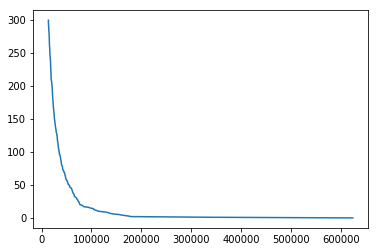

In [52]:
freqs = list(cnt_lemmas.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

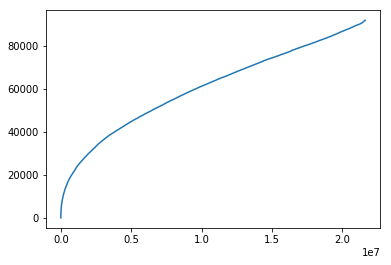

In [53]:
fig, ax = plt.subplots()
ax.plot(n_tokens_lemmas, n_types_lemmas)
plt.show()

In [67]:
w2vec = Word2Vec(sentences=df['lemmas'], min_count=20, workers=4)

In [69]:
w2vec.save('w2vec.model')

In [70]:
w2vec = Word2Vec.load('w2vec.model')

In [72]:
w2vec.wv.most_similar('ипотека')

[('автокредит', 0.8289893865585327),
 ('кредит', 0.7014356851577759),
 ('ипотечный', 0.6853820085525513),
 ('новостройка', 0.6682042479515076),
 ('потребкредит', 0.655286431312561),
 ('жилье', 0.6291305422782898),
 ('вторичка', 0.6225967407226562),
 ('недвижимость', 0.6133959293365479),
 ('дельтакредит', 0.5926231741905212),
 ('квартира', 0.5800814032554626)]

Тут аналогии расщеплются на две ветки - ипотека как банковский продукт (автокредит, кредит) и как нечто, имеющее отношение к недвижимости

In [84]:
w2vec.wv.doesnt_match('автокредит кредит новостройка'.split())

'новостройка'

In [85]:
w2vec.wv.doesnt_match('автокредит кредит ипотека'.split())

'кредит'

В данном случае, более логично исключить автокредит, т.к. ипотека является кредитом

In [86]:
w2vec.wv.doesnt_match('вклад кредит депозит'.split())

'кредит'

In [73]:
w2vec.wv.most_similar('клиент')

[('вкладчик', 0.6693146228790283),
 ('уважительный', 0.5390167236328125),
 ('наплевательский', 0.5268230438232422),
 ('клиентка', 0.5107886791229248),
 ('пользователь', 0.4935833811759949),
 ('свинский', 0.4843981862068176),
 ('скотский', 0.47814786434173584),
 ('клиентоориентированный', 0.46782824397087097),
 ('заемщик', 0.46553176641464233),
 ('халатно', 0.4643348455429077)]

Тут сразу и хороший и плохой пример - роли клиента перемешаны с оценочными суждениями

In [78]:
w2vec.wv.doesnt_match('свинский скотский уважительный'.split())

'уважительный'

In [79]:
w2vec.wv.doesnt_match('клиент вкладчик клиентка'.split())

'клиентка'

Отбор произошел по половому признаку, хотя логичнее было бы исключить вкладчика

In [93]:
w2vec.wv.most_similar(positive=['заемщик', 'вклад'], negative=['кредит'])

[('вкладчик', 0.6359438896179199),
 ('депозит', 0.5033464431762695),
 ('капитализация', 0.43838679790496826),
 ('твклад', 0.43125948309898376),
 ('сохранение', 0.4241482615470886),
 ('фк', 0.4230743944644928),
 ('исполнение', 0.4074132740497589),
 ('бпф', 0.40628722310066223),
 ('завещательный', 0.4012078642845154),
 ('смартвклад', 0.4005819857120514)]

Заемщик + вклад - кредит ~ вкладчик

In [97]:
w2vec.wv.most_similar(positive=['ипотека', 'автомобиль'], negative=['квартира'])

[('автокредит', 0.87245774269104),
 ('потребительский', 0.6631335616111755),
 ('потребкредит', 0.646970272064209),
 ('кредит', 0.6453974843025208),
 ('потреба', 0.6379214525222778),
 ('авто', 0.6351451277732849),
 ('форд', 0.6265923976898193),
 ('ипотечный', 0.6124078035354614),
 ('ниссан', 0.5786299705505371),
 ('пежо', 0.5656410455703735)]

Ипотека + автомобиль - квартира ~ автокредит

In [139]:
top_words = []

fd = FreqDist()
for text in tqdm(df.lemmas):
    fd.update(text)
for i in fd.most_common(500):
    top_words.append(i[0])
print(top_words[:15])


['банк', 'карта', 'деньги', 'день', 'мой', 'кредит', 'отделение', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год']


In [140]:
top_words = [w for w in top_words if len(w) > 4]
len(top_words)

425

In [141]:
top_words_vec = w2vec.wv[top_words]

In [142]:
tsne = TSNE(n_components=2, random_state=42)

In [143]:
top_words_tsne = tsne.fit_transform(top_words_vec)

In [144]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Хорошо виден кластер с названиями месяцов.

Определятся кластер "сотрудники банка": кассир, менеджер, представитель и т.д.

Кластер про снятие денег.

Кластер про оплаты-погашения.

Кластеры про оформление (кредита) и про выдачу находятся рядом.

задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [149]:
# достанем названия банков
df_banks = pd.DataFrame(data=df.bank_name.unique(), columns=['bank'])
len(df_banks)

670

In [166]:
def has_vector(word, word2vec=w2vec):
    try:
        return word2vec.wv[word.lower()]
    except:
        return None

In [153]:
df_banks['vec'] = df_banks['bank'].progress_apply(has_vector)

/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
df_banks.head()

,bank,vec
0,Бинбанк,"[0.57094973, -0.43747774, -1.574692, 0.5934915..."
1,Сбербанк России,None
2,ОТП Банк,None
3,Гагаринский,"[-0.43705383, -0.4302912, 0.011781587, 0.33763..."
4,Тинькофф Банк,None


In [169]:
# результат как-то не очень, надо обрабатывать вручную почти каждый банк. Воспользьуемся топом банков из прошлого дз, причем возьмем только те, название которых из одного слова или сводится к нему.
banks = ['сбер', 'сбербанк', 'альфа', 'втб', 'тинькофф', 'райффайзенбанк', 'траст', 'ренессанс', 'связной', 'юникредит', 'авангард', 'промсвязьбанк', 'хоум', 'киви', 'росбанк', 'бинбанк']
df_banks = pd.DataFrame(data=banks, columns=['bank'])
df_banks['vec'] = df_banks['bank'].progress_apply(has_vector)
df_banks

,bank,vec
0,сбер,"[0.073749, -1.2435058, -1.7942547, 0.2753542, ..."
1,сбербанк,"[-0.24204198, -0.75055695, -3.0162466, 0.12525..."
2,альфа,"[0.48206225, 1.0822564, 0.6130499, -0.23924765..."
3,втб,"[0.8892034, -0.39666823, -1.7017446, -0.183308..."
4,тинькофф,"[0.5243615, 1.2286862, -3.3026578, -0.39823803..."
5,райффайзенбанк,"[1.0115553, -0.651238, -1.9224511, 0.6155286, ..."
6,траст,"[-0.17426233, 0.9218389, -1.3105772, -1.587418..."
7,ренессанс,"[0.31311297, 0.48746285, 0.18688738, 0.9665503..."
8,связной,"[-1.3713286, 0.33701077, 1.6103327, 0.6588298,..."
9,юникредит,"[1.1958838, -0.08066127, -1.172173, 0.46789005..."


In [173]:
x_from = w2vec.wv['плохо']
x_to = w2vec.wv['хорошо']
y_from = w2vec.wv['медленно']
y_to = w2vec.wv['быстро']

In [177]:
df_banks['x'] = df_banks['vec'].apply(lambda v: v.dot(x_to - x_from))
df_banks['y'] = df_banks['vec'].apply(lambda v: v.dot(y_to - y_from))
df_banks

,bank,vec,x,y
0,сбер,"[0.073749, -1.2435058, -1.7942547, 0.2753542, ...",-24.431461,1.370444
1,сбербанк,"[-0.24204198, -0.75055695, -3.0162466, 0.12525...",-9.252349,8.609512
2,альфа,"[0.48206225, 1.0822564, 0.6130499, -0.23924765...",14.899559,24.394972
3,втб,"[0.8892034, -0.39666823, -1.7017446, -0.183308...",-2.561032,16.627838
4,тинькофф,"[0.5243615, 1.2286862, -3.3026578, -0.39823803...",-3.931417,45.333546
5,райффайзенбанк,"[1.0115553, -0.651238, -1.9224511, 0.6155286, ...",2.065663,-1.584830
6,траст,"[-0.17426233, 0.9218389, -1.3105772, -1.587418...",-3.881114,23.265673
7,ренессанс,"[0.31311297, 0.48746285, 0.18688738, 0.9665503...",10.474710,16.195784
8,связной,"[-1.3713286, 0.33701077, 1.6103327, 0.6588298,...",8.416026,36.754158
9,юникредит,"[1.1958838, -0.08066127, -1.172173, 0.46789005...",3.831338,29.463585


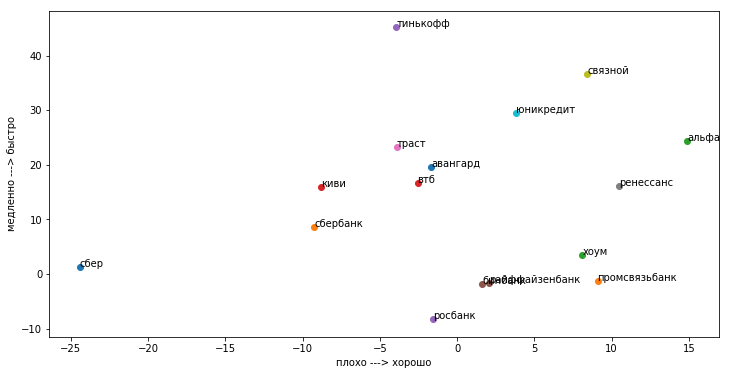

In [187]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1,1,1)

for i in range(len(df_banks)):
    x, y, text = df_banks.iloc[i]['x'], df_banks.iloc[i]['y'], df_banks.iloc[i]['bank']
    ax.scatter(x, y)
    ax.text(x, y, text)

ax.set_xlabel('плохо ---> хорошо')
ax.set_ylabel('медленно ---> быстро')

plt.show()

Самый шустрый - тинькофф, самый тормозной - росбанк, самый хороший - альфа, ну а сбер хуже всех, даже хуже сбербанка

## Часть 2. Распространение метки [50 баллов]

Определите 5-8 позитивных слов (например, “быстрый”, “удобный”) и 5-8  негативных слов (например,“очередь”, “медленно”). Эти слова будут основной будущего оценочного словаря. Пусть позитивному классу соответствует метка 1, негативному – -1. Пометьте выбранные слова в лексическом графе соответствующими метками. Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе. На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 – это и есть искомые оценочные слова.

Алгоритмы распространения метки устроены примерно так: пусть мы находимся в выршине, помеченном +1. С какой-то вероятностью мы переносим эту метку на соседние узлы. С меньшей вероятностью переносим ее на вершины на расстоянии два. В конце распространения метки, часть вершин оказывается помечена меткой +1, часть – -1, большая часть остается без метки.

Рекомендуемые алгоритмы распространения метки:
1. ```graphlab.label_propagation``` (```graphlab``` доступен бесплатно по образовательной лицензии)
2. ```sklearn.semi_supervised.LabelPropagation``` 
3. ```sklearn.semi_supervised.LabelSpreading```

In [193]:
import random

In [217]:
positive_words_start = ['быстрый', 'удобный', 'вежливый', 'качественный', 'комфортный', 'грамотный']
negative_words_start = ['очередь', 'медленно', 'отвратительный', 'совковый', 'обман', 'развод']

nodes = [(w, 1) for w in positive_words_start] + [(w, -1) for w in negative_words_start]
new_nodes = []
random.seed(42)
for word, lbl in nodes:
    for sim_word, weight in w2vec.wv.most_similar(word):
        r = random.random()
        if (weight + r) - weight * r > 0.97:
            new_nodes.append((sim_word, lbl))

new_nodes

[('доброжелательный', 1),
 ('обходительный', 1),
 ('высота', 1),
 ('профессиональный', 1),
 ('толпа', -1),
 ('шустро', -1),
 ('безответственный', -1),
 ('высокотехнологичный', -1),
 ('деревенский', -1),
 ('преднамеренный', -1),
 ('лох', -1)]

In [212]:
nodes = new_nodes

In [247]:
positive_words = ['быстрый', 'удобный', 'вежливый', 'качественный', 'комфортный', 'грамотный']
negative_words = ['очередь', 'медленно', 'отвратительный', 'совковый', 'обман', 'развод']

nodes = [(w, 1) for w in positive_words] + [(w, -1) for w in negative_words]

g = ig.Graph(directed=True)

random.seed(42)

threshold = 0.95

processed_words = positive_words + negative_words

for word, label in nodes:
    g.add_vertex(word, label=label)

while len(nodes) > 0:
    new_nodes = []

    for word, label in nodes:
        src_node = g.vs.select(name = word).indices[0]

        for sim_word, weight in w2vec.wv.most_similar(word):
            if sim_word not in processed_words:
                r = random.random()
                if (weight + r) - weight * r > threshold:
                    new_nodes.append((sim_word, label))
                    processed_words.append(word)
                    if label == 1:
                        positive_words.append(sim_word)
                    else:
                        negative_words.append(sim_word)
                    
                    g.add_vertex(sim_word, label=label)
                    trg_node = g.vs.select(name = sim_word).indices[0]
                    g.add_edge(src_node, trg_node, label = lbl)
    nodes = new_nodes

In [248]:
print(f"Total words: {len(w2vec.wv.vocab.keys())}, positive words: {len(positive_words)}, negative_words: {len(negative_words)}")

Total words: 17204, positive words: 5492, negative_words: 3860
